**Phân cụm bằng thuật toán DBSCAN**
Trong notebook này, ta sẽ áp dụng thuật toán **DBSCAN (Density-Based Spatial Clustering of Applications with Noise)**  
để phân cụm dữ liệu khách hàng từ bộ dữ liệu `Wholesale_customers_data.csv`. Tập dữ liệu Wholesale Customers Data bao gồm 440 mẫu và 8 thuộc tính chính, trong đó có 2 thuộc tính phân loại (categorical) và 6 thuộc tính liên tục (continuous) thể hiện chi tiêu hàng năm (tính bằng đơn vị tiền tệ) của khách hàng trên các danh mục sản phẩm khác nhau:

2 Thuộc tính Phân loại (Categorical Features) - Các thuộc tính này mô tả loại hình hoặc vị trí của khách hàng:
* Channel (Kênh): Phân loại khách hàng thuộc kênh phân phối nào.
    1. Horeca (Hotel/Restaurant/Cafe - Khách sạn/Nhà hàng/Quán cà phê)
    2. Retail (Bán lẻ - Các cửa hàng bán lẻ, siêu thị)
* Region (Khu vực): Vị trí địa lý của khách hàng (thường là các thành phố hoặc khu vực chính).
    1. Lisbon
    2. Oporto
    3. Other (Các khu vực khác)

6 Thuộc tính Chi tiêu (Spending Features) - Các thuộc tính này đại diện cho chi tiêu hàng năm của khách hàng (bằng đơn vị tiền tệ - m.u.) trên các danh mục sản phẩm:
* Fresh: Chi tiêu cho các sản phẩm tươi sống (thịt, rau, trái cây, v.v.).
* Milk: Chi tiêu cho các sản phẩm sữa (sữa tươi, sữa bột, phô mai, v.v.).
* Grocery: Chi tiêu cho hàng tạp hóa (thực phẩm đóng gói, đồ hộp, v.v.).
* Frozen: Chi tiêu cho các sản phẩm đông lạnh (thực phẩm, rau củ đông lạnh, v.v.).
* Detergents_Paper: Chi tiêu cho chất tẩy rửa và sản phẩm giấy (bột giặt, giấy vệ sinh, khăn giấy, v.v.).
* Delicassen: Chi tiêu cho các sản phẩm chế biến sẵn/đặc sản (thịt nguội, thực phẩm ăn liền cao cấp, v.v.).

**Các bước thực hiện:**
1. Đọc và phân tích dữ liệu.
2. Tiền xử lý, chuẩn hóa và giảm chiều dữ liệu.
3. Chạy thuật toán DBSCAN.
4. Đánh giá và trực quan hóa kết quả.

In [2]:
# import thư viện
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

### Giải thích tác dụng của các thư viện đã import
- **pandas (pd)**: xử lý dữ liệu dạng bảng (DataFrame). Dùng để đọc/ghi CSV, lọc, nhóm (groupby), tính toán thống kê và xử lý dữ liệu tổng hợp.
- **numpy (np)**: thư viện toán học số; cung cấp kiểu mảng hiệu năng cao (ndarray) và các phép toán ma trận, cần thiết cho nhiều thao tác tiền xử lý và cho scikit-learn.
- **matplotlib.pyplot (plt)**: thư viện vẽ biểu đồ cơ bản (line, scatter, histogram, ...). Dùng để hiển thị các biểu đồ và figure.
- **seaborn (sns)**: thư viện trực quan dữ liệu cao cấp dựa trên matplotlib; hỗ trợ tạo biểu đồ thống kê đẹp (boxplot, violin, kde, countplot, ...).
- **StandardScaler (sklearn.preprocessing)**: chuẩn hóa dữ liệu (zero mean, unit variance). Rất hữu ích trước PCA hoặc nhiều thuật toán ML để cân bằng thang đo các đặc trưng.
- **PCA (sklearn.decomposition)**: Phân tích thành phần chính để giảm chiều dữ liệu; giúp trực quan hóa và giảm noise, đồng thời tăng tốc các thuật toán phân cụm.
- **DBSCAN (sklearn.cluster)**: Thuật toán phân cụm theo mật độ, tự phát hiện điểm nhiễu (noise) và không cần biết trước số cụm.
- **silhouette_score (sklearn.metrics)**: chỉ số dùng để đánh giá chất lượng phân cụm (giữa-các-cụm so với-trong-cụm); giá trị gần 1 là tốt, gần -1 là không tốt.
- **NearestNeighbors (sklearn.neighbors)**: công cụ tính khoảng cách k-láng giềng; thường dùng để vẽ K-distance plot giúp chọn tham số eps cho DBSCAN.


 tự động trên đồ thị k-distance.Ghi chú: trong các cell khác chúng ta cũng sử dụng `scipy.stats.skew` để kiểm tra độ lệch (skewness) và `kneed.KneeLocator` để tìm điểm 

## 1. Đọc và phân tích dữ liệu
**Đọc dữ liệu vào**

In [3]:
df = pd.read_csv("Wholesale_customers_data.csv")

In [4]:
print("10 dữ liệu đầu:")
df.head(10)

10 dữ liệu đầu:


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
5,2,3,9413,8259,5126,666,1795,1451
6,2,3,12126,3199,6975,480,3140,545
7,2,3,7579,4956,9426,1669,3321,2566
8,1,3,5963,3648,6192,425,1716,750
9,2,3,6006,11093,18881,1159,7425,2098


In [5]:
print("\n10 dữ liệu cuối:")
df.tail(10)


10 dữ liệu cuối:


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
430,1,3,3097,4230,16483,575,241,2080
431,1,3,8533,5506,5160,13486,1377,1498
432,1,3,21117,1162,4754,269,1328,395
433,1,3,1982,3218,1493,1541,356,1449
434,1,3,16731,3922,7994,688,2371,838
435,1,3,29703,12051,16027,13135,182,2204
436,1,3,39228,1431,764,4510,93,2346
437,2,3,14531,15488,30243,437,14841,1867
438,1,3,10290,1981,2232,1038,168,2125
439,1,3,2787,1698,2510,65,477,52


**Kiểm tra thông tin dữ liệu**

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


Dữ liệu gồm 440 mẫu và 8 thuộc tính dạng numberic (int64)

**Hiển thị tóm tắt thống kê của dữ liệu**

In [7]:
print(df.describe())

          Channel      Region          Fresh          Milk       Grocery  \
count  440.000000  440.000000     440.000000    440.000000    440.000000   
mean     1.322727    2.543182   12000.297727   5796.265909   7951.277273   
std      0.468052    0.774272   12647.328865   7380.377175   9503.162829   
min      1.000000    1.000000       3.000000     55.000000      3.000000   
25%      1.000000    2.000000    3127.750000   1533.000000   2153.000000   
50%      1.000000    3.000000    8504.000000   3627.000000   4755.500000   
75%      2.000000    3.000000   16933.750000   7190.250000  10655.750000   
max      2.000000    3.000000  112151.000000  73498.000000  92780.000000   

             Frozen  Detergents_Paper    Delicassen  
count    440.000000        440.000000    440.000000  
mean    3071.931818       2881.493182   1524.870455  
std     4854.673333       4767.854448   2820.105937  
min       25.000000          3.000000      3.000000  
25%      742.250000        256.750000    408.

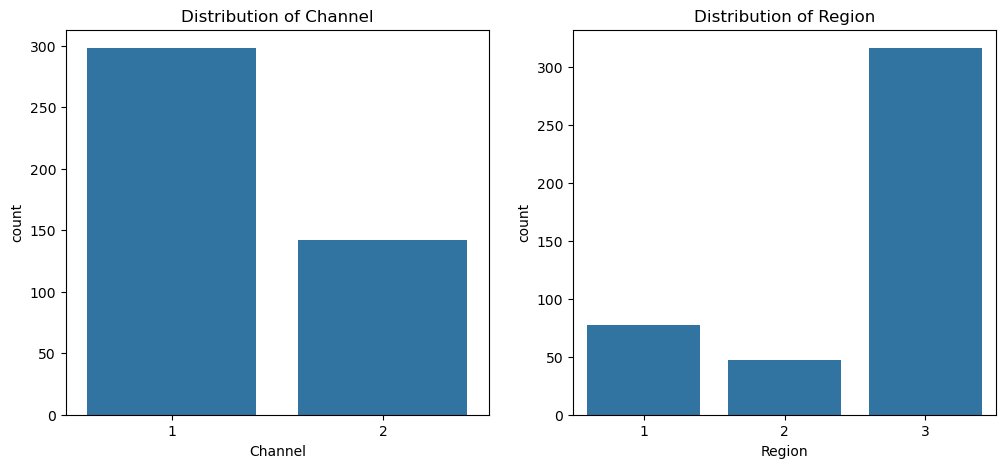

In [8]:
# Hiển thị phân bố của các thuộc tính phân loại
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(data=df, x='Channel')
plt.title('Distribution of Channel')

plt.subplot(1, 2, 2)
sns.countplot(data=df, x='Region')
plt.title('Distribution of Region')

plt.show()

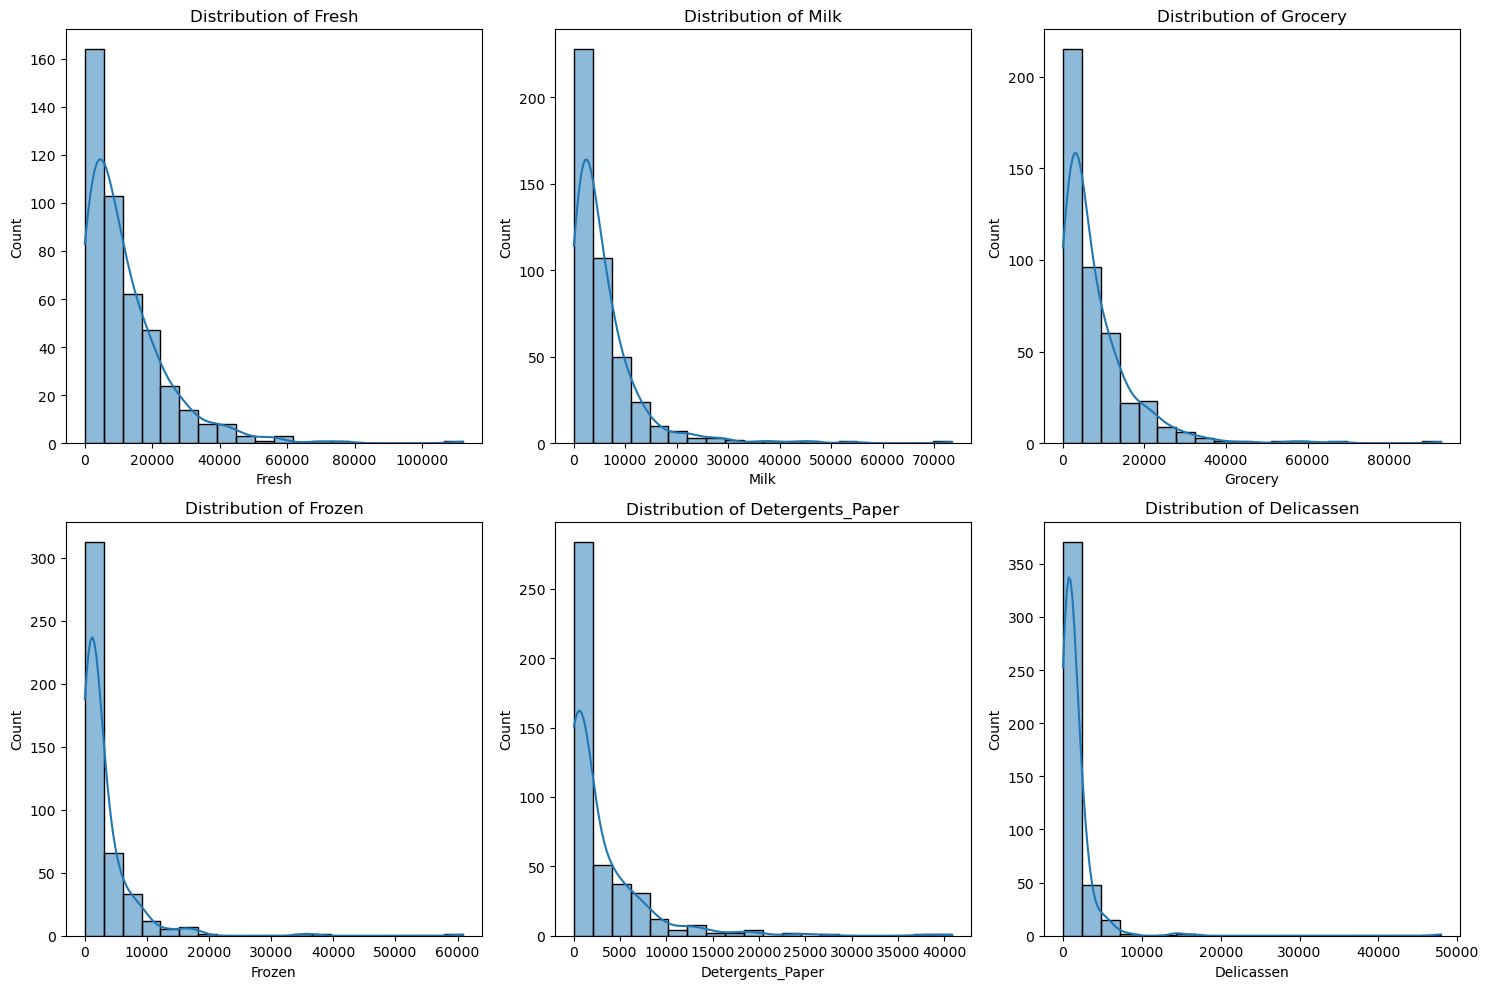

In [ ]:
# Hiển thị phân bố của các thuộc tính chi tiêu (liên tục)
continuous_features = ['-', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']

plt.figure(figsize=(15, 10))

for i, feature in enumerate(continuous_features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[feature], bins=20, kde=True)
    plt.title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()

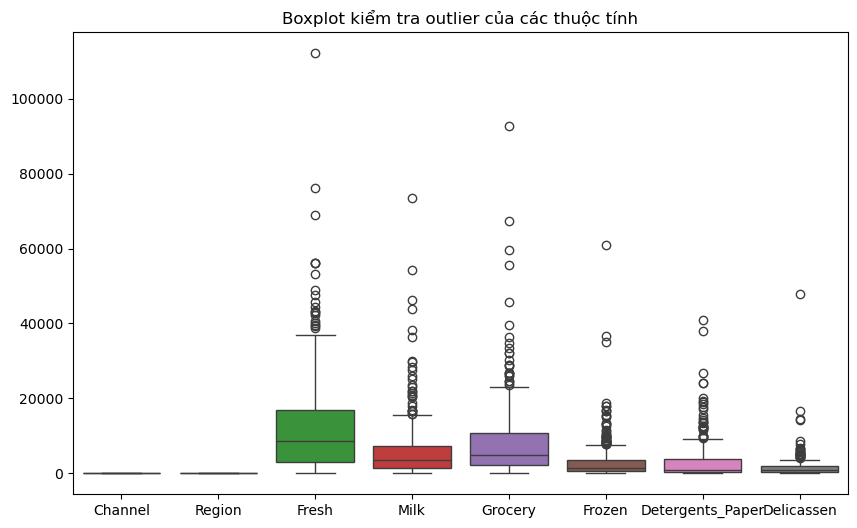

In [10]:
# Biểu đồ hộp kiểm tra outlier
plt.figure(figsize=(10,6))
sns.boxplot(data=df)
plt.title("Boxplot kiểm tra outlier của các thuộc tính")
plt.show()

In [11]:
from scipy.stats import skew
# Kiểm tra độ lệch(Skewness) của các thuộc tính số
for feature in continuous_features:
    print(f'Độ lệch của {feature}: {skew(df[feature])}')

Độ lệch của Fresh: 2.5525826879071585
Độ lệch của Milk: 4.039922122788577
Độ lệch của Grocery: 3.5751872200807875
Độ lệch của Frozen: 5.887825728957787
Độ lệch của Detergents_Paper: 3.6194575783115934
Độ lệch của Delicassen: 11.113533648709097


Phân bố dữ liệu và outliers
- Các thuộc tính chi tiêu (Fresh, Milk, Grocery, Frozen, Detergents_Paper, Delicassen) có phân bố lệch phải (right-skewed): nhiều khách hàng chi ít, một vài khách hàng chi rất nhiều.
- Hình hộp (boxplot) cho thấy tồn tại một số outliers/giá trị ngoại lai, điều này là bình thường trong dữ liệu chi tiêu thương mại.

## 2. Tiền xử lý, chuẩn hóa và giảm chiều dữ liệu
**2.1. Tiền xử lý và chuẩn hóa dữ liệu**

In [12]:
# Kiểm tra dữ liệu bị thiếu
print(df.isnull().sum())

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64


Dữ liệu `Wholesale customers` có phân bố lệch nên ta áp dụng log-transform để giảm skewness, sau đó chuẩn hóa dữ liệu bằng `StandardScaler` để cân bằng thang đo giữa các thuộc tính.

Vì sao log-transform?
- Log-transform (sử dụng np.log1p) giúp làm giảm skewness, kéo các giá trị lớn về gần nhóm chính, làm cho nhiều thuật toán (PCA, DBSCAN) hoạt động ổn định hơn và trực quan hơn khi dùng log-scale để hiển thị.

Chuẩn hóa (StandardScaler):
- Sau log-transform, các đặc trưng vẫn có độ biến thiên khác nhau. StandardScaler chuẩn hóa mỗi đặc trưng về mean=0, std=1, giúp các thuật toán phụ thuộc khoảng cách (DBSCAN, PCA) không bị chi phối bởi đơn vị/thang đo khác nhau.

In [13]:
# Đây là bước quan trọng nhất để loại bỏ Channel và Region.
spending_features = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']
X = df[spending_features].copy() # Sử dụng .copy() để tránh SettingWithCopyWarning

# --- BƯỚC 2: LOG-TRANSFORM ---
# Áp dụng log-transform để giảm skewness cho 6 cột chi tiêu.
X_log = np.log1p(X)

# --- BƯỚC 3: CHUẨN HÓA DỮ LIỆU ---
# Chuẩn hóa dữ liệu đã được log-transform.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_log)

print("Dữ liệu gốc có dạng:", df.shape)
print("Dữ liệu chi tiêu đã chuẩn hóa có dạng:", X_scaled.shape)

Dữ liệu gốc có dạng: (440, 8)
Dữ liệu chi tiêu đã chuẩn hóa có dạng: (440, 6)


In [14]:
# --- BƯỚC 4: CHUYỂN ĐỔI THÀNH DATAFRAME VÀ IN DỮ LIỆU ---

# 4.1. Chuyển mảng NumPy X_scaled thành DataFrame
# Ta sử dụng các tên cột đã dùng để lọc ở bước trước.
df_scaled = pd.DataFrame(X_scaled, columns=spending_features)

# 4.2. In 10 dòng dữ liệu đầu tiên
print("\n10 dữ liệu đầu tiên sau khi Log-transform và Chuẩn hóa:")
print(df_scaled.head(10))

# --- BƯỚC 5: XUẤT FILE CSV ---

# 5.1. Xuất DataFrame đã chuẩn hóa ra tệp CSV
from pathlib import Path
# Tạo đường dẫn tuyệt đối trong cùng thư mục notebook (Btnhom)
output_dir = Path(".").resolve()  # Thư mục làm việc hiện tại của notebook
file_name = 'wholesale_customers_scaled.csv'
file_path = output_dir / file_name
df_scaled.to_csv(file_path, index=False)

print()
print(f'Đã xuất dữ liệu chuẩn hóa thành công ra tệp: {file_name}')
print(f'Đường dẫn tuyệt đối của tệp xuất: {file_path}')


10 dữ liệu đầu tiên sau khi Log-transform và Chuẩn hóa:
      Fresh      Milk   Grocery    Frozen  Detergents_Paper  Delicassen
0  0.486184  0.976299  0.440155 -1.509250          0.644143    0.408966
1  0.087889  0.990956  0.652171  0.134052          0.766043    0.627926
2  0.016356  0.891151  0.454687  0.376899          0.804405    1.776833
3  0.517477 -0.957973 -0.084792  1.141574         -0.328712    0.633133
4  0.880631  0.439662  0.395847  0.757322          0.404939    1.456588
5  0.283972  0.831535  0.090133 -0.625053          0.410837    0.471650
6  0.456365 -0.046979  0.367505 -0.880376          0.738190   -0.285090
7  0.136462  0.358475  0.638705  0.091728          0.771000    0.912502
8 -0.026765  0.074664  0.260272 -0.975210          0.384494   -0.038444
9 -0.021875  1.104815  1.264352 -0.192867          1.242089    0.756774

Đã xuất dữ liệu chuẩn hóa thành công ra tệp: wholesale_customers_scaled.csv
Đường dẫn tuyệt đối của tệp xuất: D:\Thuat_toan_DBSCAN_NV1\Btnhom\wholesal

**2.2. Giảm chiều dữ liệu (PCA)**

Để DBSCAN hoạt động ổn định và dễ trực quan hóa, ta giảm dữ liệu từ 6 đặc trưng xuống **2 thành phần chính** bằng **PCA**.  
Việc này giúp:
- Dễ hình dung cụm trong không gian.
- Tăng tốc độ tính toán cho DBSCAN.

Text(0.5, 1.0, 'Cumulative Explained Variance by PCA Components')

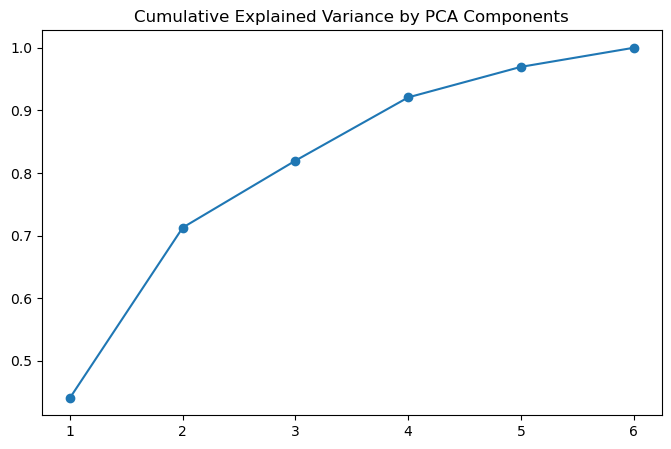

In [ ]:
# Tìm số thành phần chính để giữ lại 90% phương sai
pca = PCA()
pca.fit(X_scaled)
# Lấy cumulative variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.title('Cumulative Explained Variance by PCA Components')

Từ kết quả hình trên, ta thấy được nên giảm xuống 4 chiều để phương sai đạt từ 90% trở lên, nếu dưới ngưỡng này, dữ liệu có thể xảy ra mất mát.

In [34]:
pca = PCA(n_components=4)
X_reduced = pca.fit_transform(X_scaled)

print("Tỷ lệ phương sai giữ lại:", np.sum(pca.explained_variance_ratio_))
print("Dạng dữ liệu sau PCA:", X_reduced.shape)


Tỷ lệ phương sai giữ lại: 0.9207438414596261
Dạng dữ liệu sau PCA: (440, 4)


## 3. Chạy thuật toán DBSCAN
**Bước 1: Xác đinh tham số epsilon và minpoint (min_simple)**

DBSCAN có hai tham số chính:

- **eps (ε)**: bán kính lân cận mà trong đó các điểm được xem là “hàng xóm”.
- **min_samples**: số lượng điểm tối thiểu cần có trong vùng lân cận để tạo thành một cụm.

Việc chọn ε quá **nhỏ** sẽ khiến dữ liệu bị chia nhỏ thành quá nhiều cụm hoặc nhiều điểm bị xem là nhiễu. Ngược lại, ε quá **lớn** sẽ khiến các cụm bị dính lại thành một khối lớn, làm mất ý nghĩa phân cụm.

Một cách phổ biến để chọn ε là **vẽ đồ thị khoảng cách k-láng giềng gần nhất** (k thường = `min_samples`). Ta tìm **điểm gấp khúc (elbow)** trên đồ thị — đó chính là giá trị ε tốt nhất, vì sau điểm này, khoảng cách tăng nhanh → tức là vượt ra khỏi ranh giới cụm.

In [17]:
# Tính min_simple (MinPts)
n_samples, n_dims = X_reduced.shape
min_simple = 2 * n_dims   # theo quy tắc: MinPts ≈ 2 * số chiều
print(f"\nSố mẫu: {n_samples}, Số chiều (PCA): {n_dims}, min_simple (MinPts đề xuất): {min_simple}")


Số mẫu: 440, Số chiều (PCA): 4, min_simple (MinPts đề xuất): 8


✅ Epsilon được chọn: 2.3028 (vị trí index=423)


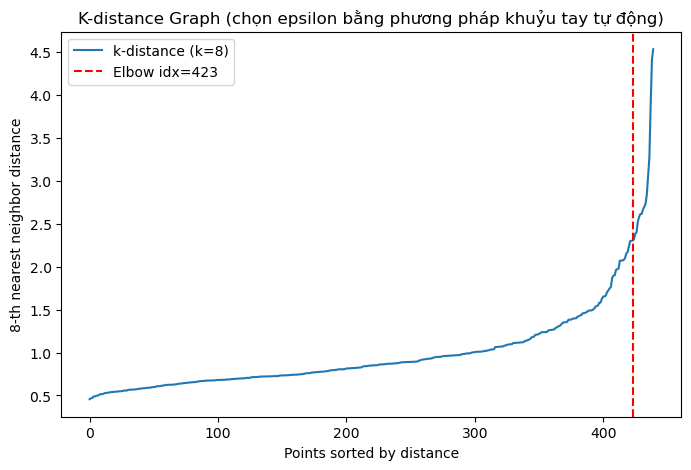

In [18]:
from kneed import KneeLocator # Khai báo lớp KneeLocator từ thư viện kneed

K = min_simple
# Bước 1: Tính khoảng cách k-lân cận
neigh = NearestNeighbors(n_neighbors=K) # Khởi tạo mô hình KNN
nbrs = neigh.fit(X_reduced) # Huấn luyện mô hình 
distances, indices = nbrs.kneighbors(X_reduced) #Tính toán và trả về khoảng cách (distances) và chỉ số (indices) của KNN

k_distances = distances[:, K-1]  #Lấy cột cuối cùng trong mảng distances (cột thứ K−1, tức cột thứ 7) để thu được khoảng cách đến láng giềng gần nhất thứ K cho mỗi điểm.
k_distances = np.sort(k_distances, axis=0) # Sắp xếp tăng dần

# Bước 2: Tìm điểm khuỷu tay tự động bằng KneeLocator
x = np.arange(len(k_distances)) # Tạo mảng chỉ số cho các điểm
knee = KneeLocator(x, k_distances, curve='convex', direction='increasing')
# Tự động xác định vị trí điểm khuỷu tay (elbow point) trên đồ thị K-distance.
epsilon = k_distances[knee.knee]

print(f"✅ Epsilon được chọn: {epsilon:.4f} (vị trí index={knee.knee})")

# Bước 3: Vẽ biểu đồ minh họa
plt.figure(figsize=(8,5))
plt.plot(k_distances, label=f'k-distance (k={K})')
plt.axvline(x=knee.knee, color='r', linestyle='--', label=f'Elbow idx={knee.knee}')
plt.title("K-distance Graph (chọn epsilon bằng phương pháp khuỷu tay tự động)")
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{K}-th nearest neighbor distance")
plt.legend()
plt.show()

**Bước 2: Chạy thuật toán DBSCAN**
Chạy thuật toán và dùng Silhouette để đánh giá mô hình tốt nhất

In [19]:
# --- Sau khi nhìn đồ thị, ta thấy elbow khoảng eps ≈ 2.3028 ---
eps_candidates = np.arange(epsilon*0.2, epsilon*1.5, 0.01)  # quét quanh 2.3028
min_samples = 8 # Thiết lập Min_Samples
best_score, best_eps, best_labels = -1, None, None # Khởi tạo biến theo dõi

for eps in eps_candidates:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples) # Khởi tạo mô hình DBSCAN 
    labels = dbscan.fit_predict(X_scaled) # Áp dụng DBSCAN 

    # Kiểm tra số cụm tìm được (loại trừ noise - nhãn -1)
    if len(set(labels)) > 1 and len(set(labels)) != 1 + (-1 in labels): #Điều kiện lọc
        score = silhouette_score(X_scaled, labels) # Tính toán Silhouette Score 
        print(f"eps={eps:.2f}, silhouette={score:.4f}, clusters={len(set(labels)) - (1 if -1 in labels else 0)}") 
        if score > best_score: # ktra mô hình tốt nhất
            best_score, best_eps, best_labels = score, eps, labels # Cập nhật

eps=0.61, silhouette=-0.2983, clusters=2
eps=0.62, silhouette=-0.2909, clusters=2
eps=0.63, silhouette=-0.2845, clusters=2
eps=0.64, silhouette=-0.2845, clusters=2
eps=0.65, silhouette=-0.3096, clusters=3
eps=0.66, silhouette=-0.3023, clusters=3
eps=0.67, silhouette=-0.2991, clusters=3
eps=0.68, silhouette=-0.2969, clusters=3
eps=0.69, silhouette=-0.2969, clusters=3
eps=0.70, silhouette=-0.2955, clusters=3
eps=0.71, silhouette=-0.2996, clusters=4
eps=0.72, silhouette=-0.2455, clusters=3
eps=0.73, silhouette=-0.2351, clusters=3
eps=0.74, silhouette=-0.2235, clusters=3
eps=0.75, silhouette=-0.2060, clusters=4
eps=0.76, silhouette=-0.1896, clusters=4
eps=0.77, silhouette=-0.1713, clusters=4
eps=0.78, silhouette=-0.1539, clusters=4
eps=0.79, silhouette=-0.1831, clusters=4
eps=0.80, silhouette=-0.0407, clusters=2
eps=0.81, silhouette=-0.0242, clusters=2
eps=0.82, silhouette=-0.0128, clusters=2
eps=0.83, silhouette=-0.0128, clusters=2
eps=0.84, silhouette=0.0071, clusters=2
eps=0.85, silhoue

In [20]:
 # Kiểm tra kết quả nếu không tìm được mô hình DBSCAN hợp lệ trong dải ϵ.
if best_eps is None:
    print("\n Không tìm được mô hình DBSCAN hợp lệ trong dải `eps_candidates`. Hãy thử mở rộng dải eps hoặc thay đổi `min_samples`.")
else:
    print(f"\n Best model: eps={best_eps}, min_samples={min_samples}, silhouette={best_score:.4f}")


 Best model: eps=1.080550257024612, min_samples=8, silhouette=0.0841


In [ ]:
# --- Lưu nhãn cụm vào dataset (nếu có) ---
if best_labels is None:
    print('best_labels is None: không có nhãn hợp lệ để lưu vào df["Cluster"].')
else:
    df['Cluster'] = best_labels
    print("\n10 dữ liệu đầu tiên với nhãn cụm:")
    print(df.head(10))



10 dữ liệu đầu tiên với nhãn cụm:
   Channel  Region  Fresh   Milk  Grocery  Frozen  Detergents_Paper  \
0        2       3  12669   9656     7561     214              2674   
1        2       3   7057   9810     9568    1762              3293   
2        2       3   6353   8808     7684    2405              3516   
3        1       3  13265   1196     4221    6404               507   
4        2       3  22615   5410     7198    3915              1777   
5        2       3   9413   8259     5126     666              1795   
6        2       3  12126   3199     6975     480              3140   
7        2       3   7579   4956     9426    1669              3321   
8        1       3   5963   3648     6192     425              1716   
9        2       3   6006  11093    18881    1159              7425   

   Delicassen  Cluster  
0        1338        0  
1        1776        0  
2        7844        0  
3        1788        0  
4        5185        0  
5        1451        0  
6       

In [22]:

print("10 dữ liệu cuối cùng với nhãn cụm:")
print(df.tail(10))

10 dữ liệu cuối cùng với nhãn cụm:
     Channel  Region  Fresh   Milk  Grocery  Frozen  Detergents_Paper  \
430        1       3   3097   4230    16483     575               241   
431        1       3   8533   5506     5160   13486              1377   
432        1       3  21117   1162     4754     269              1328   
433        1       3   1982   3218     1493    1541               356   
434        1       3  16731   3922     7994     688              2371   
435        1       3  29703  12051    16027   13135               182   
436        1       3  39228   1431      764    4510                93   
437        2       3  14531  15488    30243     437             14841   
438        1       3  10290   1981     2232    1038               168   
439        1       3   2787   1698     2510      65               477   

     Delicassen  Cluster  
430        2080       -1  
431        1498        0  
432         395        0  
433        1449        0  
434         838        0  

In [ ]:
print(df['Cluster'])

0      0
1      0
2      0
3      0
4      0
      ..
435   -1
436    0
437    0
438    0
439   -1
Name: Cluster, Length: 440, dtype: int64


## 4. Đánh giá và trực quan hóa dữ liệu

In [23]:
# 4.1. Phân tích đặc điểm của các cụm
# Tính giá trị trung bình của các thuộc tính trong mỗi cụm

 # Kiểm tra nếu cột 'Cluster' chưa tồn tại trong DataFrame gốc (df).
if 'Cluster' not in df.columns:
    if best_labels is not None: # ktra giá trị best_labels
        df['Cluster'] = best_labels # Gán nhãn
    else:
        print("Lỗi: Không tìm thấy nhãn cụm hợp lệ (best_labels is None). Không thể phân tích.") 
        exit()

# Lấy các cột chi tiêu gốc để tính trung bình
spending_features = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']

# Tính giá trị trung bình của các thuộc tính chi tiêu trong mỗi cụm
cluster_analysis = df.groupby('Cluster')[spending_features].mean() #

print("\nPhân tích đặc điểm của các cụm (giá trị trung bình của các thuộc tính chi tiêu):")
print(cluster_analysis)
print("\n")


Phân tích đặc điểm của các cụm (giá trị trung bình của các thuộc tính chi tiêu):
                Fresh         Milk       Grocery       Frozen  \
Cluster                                                         
-1       11380.025862  8636.568966  11474.913793  3495.086207   
 0       12462.697161  4684.785489   6522.788644  2981.700315   
 1        1339.000000  9062.571429  14249.714286   145.857143   

         Detergents_Paper   Delicassen  
Cluster                                 
-1            4210.905172  1980.370690  
 0            2320.296530  1358.239748  
 1            6265.428571  1522.571429  




In [27]:
# 🔹 So sánh nhãn cụm với biến Channel (để xem phân cụm có ý nghĩa thực tế không)
print("BẢNG SO SÁNH GIỮA CỤM VÀ CHANNEL:")
print(pd.crosstab(df['Cluster'], df['Channel']))
print("\n")

BẢNG SO SÁNH GIỮA CỤM VÀ CHANNEL:
Channel    1    2
Cluster          
-1        81   35
 0       217  100
 1         0    7




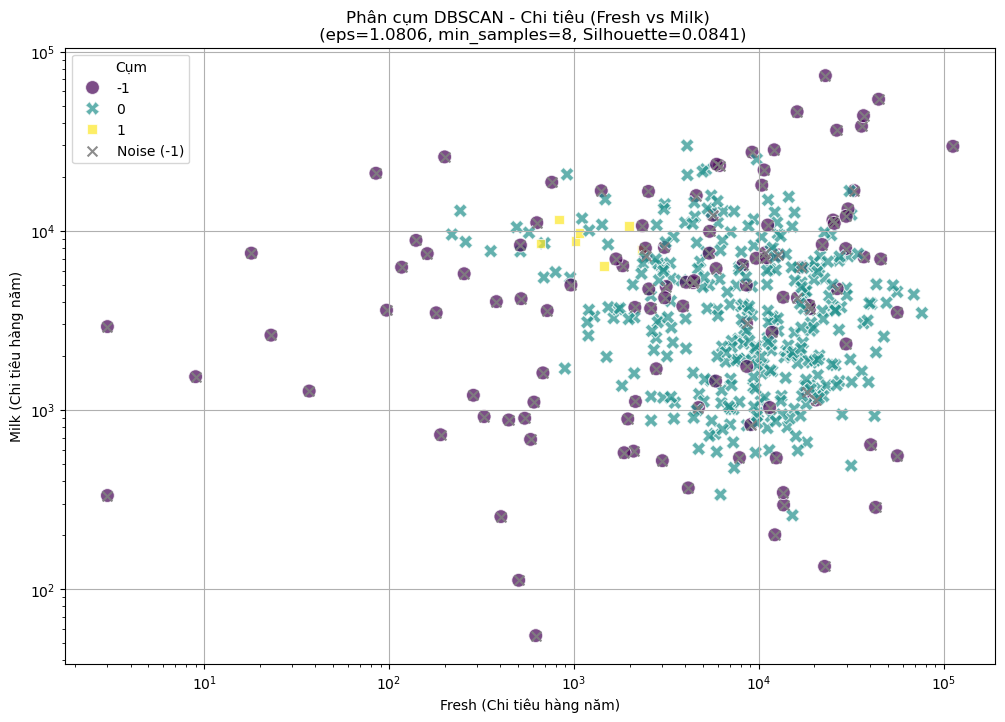

In [24]:
# 4.2 Trực quan hóa trên dữ liệu chi tiêu GỐC (Fresh vs Milk)
plt.figure(figsize=(12, 8)) # Khởi tạo 
# Vẽ biểu đồ phân tán 
sns.scatterplot(
    x='Fresh',
    y='Milk',
    hue='Cluster', 
    data=df, # Sử dụng DataFrame gốc (df) đã có cột 'Cluster'.
    palette='viridis', 
    style='Cluster', 
    s=100, 
    alpha=0.7 
)

# Đánh dấu các điểm nhiễu (-1) nổi bật hơn (tùy chọn)
noise = df[df['Cluster'] == -1] # Lọc nhiễu
plt.scatter(noise['Fresh'], noise['Milk'], color='gray', marker='x', s=50, label='Noise (-1)', alpha=0.9) 

plt.title(f'Phân cụm DBSCAN - Chi tiêu (Fresh vs Milk) \n (eps={best_eps:.4f}, min_samples={min_samples}, Silhouette={best_score:.4f})')
plt.xlabel('Fresh (Chi tiêu hàng năm)')
plt.ylabel('Milk (Chi tiêu hàng năm)')
plt.legend(title='Cụm')
plt.grid(True)
plt.xscale('log') # Thang đo Logarit (X): Chuyển trục X (Fresh) sang thang đo logarit.
plt.yscale('log') # Thang đo Logarit (Y): Chuyển trục Y (Milk) sang thang đo logarit.
plt.show()

In [25]:
from collections import deque
NOISE = 0
UNCLASSIFIED = -1

def get_neighbors(data, point_index, eps): # dùng để tính khoảng cách từ điểm đang xét đến tất cả các điểm khác và trả về các điểm trong bán kính eps
    """Tìm tất cả các điểm lân cận của một điểm p (trong bán kính eps)"""
    # Sử dụng khoảng cách Euclidean (L2-norm)
    distances = np.linalg.norm(data - data[point_index], axis=1)
    return np.where(distances <= eps)[0]

def dbscan(data, eps, min_pts):
    """
    Thuật toán DBSCAN
    
    Tham số:
    - data (np.array): Tập dữ liệu
    - eps (float): Bán kính lân cận
    - min_pts (int): Số điểm tối thiểu để tạo thành vùng dày đặc
    
    Trả về:
    - labels (np.array): Mảng chứa nhãn cụm (số nguyên) cho mỗi điểm.
                         0 là điểm nhiễu (Noise).
    """
    
    # 1. KHỞI TẠO: Nhãn cụm cho mỗi điểm (-1: chưa phân loại) => đánh dấu tất cả điểm là chưa thăm
    labels = np.full(data.shape[0], UNCLASSIFIED, dtype=int)
    current_cluster_id = 1 # ID cụm bắt đầu từ 1

    # 2. QUÉT VÀ KIỂM TRA MẬT ĐỘ:
    for i in range(data.shape[0]): # Với mỗi điểm p trong tập dữ liệu => duyệt qua tất cả điểm
        # Bỏ qua các điểm đã được phân loại (hoặc đang được xử lý)
        if labels[i] != UNCLASSIFIED:
            continue
            
        # Tìm các điểm lân cận
        neighbors = get_neighbors(data, i, eps)
        
        # KIỂM TRA ĐIỂM LÕI
        if len(neighbors) < min_pts:
            # Điểm không phải là điểm lõi, tạm thời đánh dấu là nhiễu
            labels[i] = NOISE
            continue
            
        # 3. MỞ RỘNG CỤM: Nếu là Điểm Lõi, bắt đầu cụm mới
        labels[i] = current_cluster_id
        
        # HÀM MỞ RỘNG CỤM (TÌM KIẾM THEO CHIỀU RỘNG - BFS)
        # Sử dụng deque (hàng đợi) cho BFS => khởi tạo danh sách ứng viên
        queue = deque(neighbors)
        
        # Với mỗi điểm q trong N: Nếu q chưa được thăm → đánh dấu đã thăm, kiểm tra N(q)
        while queue:
            p_index = queue.popleft()
            
            # Nếu đã là nhiễu, chuyển nó thành một Điểm Biên của cụm hiện tại
            if labels[p_index] == NOISE:
                labels[p_index] = current_cluster_id
            
            # Bỏ qua nếu đã được phân loại thành cụm khác
            if labels[p_index] != UNCLASSIFIED:
                continue

            labels[p_index] = current_cluster_id # Gán nhãn cụm
            
            # Tìm lân cận của điểm mới (p_index)
            new_neighbors = get_neighbors(data, p_index, eps)

            # KIỂM TRA ĐIỂM LÕI MỚI VÀ MỞ RỘNG TIẾP
            if len(new_neighbors) >= min_pts: 
                # Nếu p_index cũng là điểm lõi, thêm tất cả lân cận của nó vào hàng đợi
                # để tiếp tục mở rộng (density-reachable)
                for neighbor_index in new_neighbors:
                    if labels[neighbor_index] == UNCLASSIFIED or labels[neighbor_index] == NOISE:
                        queue.append(neighbor_index)

        # Chuyển sang ID cụm tiếp theo cho lần lặp sau
        current_cluster_id += 1
        
    return labels

if __name__ == '__main__':

    # Thiết lập tham số
    EPS = epsilon
    MIN_PTS = min_samples

    # Chạy thuật toán
    cluster_labels = dbscan(X_reduced, EPS, MIN_PTS)

    print("Dữ liệu:\n", X_reduced)
    print("\nNhãn cụm (0 là Noise):\n", cluster_labels)

Dữ liệu:
 [[ 1.38038279 -0.30472683 -0.2410617  -1.41571932]
 [ 1.43886964  0.53746823  0.0842323   0.03092821]
 [ 1.51345256  1.23256453  0.98530594 -0.16852208]
 ...
 [ 2.85257677  0.19460002 -0.52435731 -0.88014849]
 [-1.01176679  0.45278455  0.66045788 -0.8298864 ]
 [-0.91564089 -2.91826108 -0.9249211  -1.0532505 ]]

Nhãn cụm (0 là Noise):
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 